In [4]:
%load_ext autoreload
%autoreload 
import Bayes_fun as bf
import utils as util
import Overlord
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#get default parameters, can add your own before or after!
param = util.get_default_param()


# Load in the data
#The channel position i.e location of active channels is assumed to be the same for all recording sessions
ChannelPos1 = np.load(r'Data\Mouse1\AL032\2019-11-21\Probe0\1\channel_positions.npy')
#This makes position 3-D by inserting an axis of all one's in the first axis, to allow easy extension to 3-D coords
ChannelPos1 = np.insert(ChannelPos1,0, np.ones(ChannelPos1.shape[0]), axis =1)

ChannelPos = [ChannelPos1, ChannelPos1] # Want it per session, however usually will be the same

#path to the average waveforms for each session
WavePath1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\RawWaveforms'
WavePath2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\RawWaveforms'
WavePath3 = r'Data\Mouse1\AL032\2019-12-03\RawWaveforms'

#path to a tsv file, where the second column contains 'good' for all units you want to include
UnitLabelPath1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\cluster_group.tsv'
UnitLabelPath2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\cluster_group.tsv'
UnitLabelPath3 = r'Data\Mouse1\AL032\2019-12-03\cluster_group.tsv'

#make paths into a list
# WavePaths = [WavePath1 , WavePath2]
# UnitLabelPaths = [UnitLabelPath1, UnitLabelPath2]

# Un-comment below if wanting to use 3 sessions 
WavePaths = [WavePath1 , WavePath2,WavePath3]
UnitLabelPaths = [UnitLabelPath1, UnitLabelPath2, UnitLabelPath3]
ChannelPos = [ChannelPos1, ChannelPos1, ChannelPos1]


In [6]:

#read in data and select the good units and exact metadata
waveform, SessionID, SessionSwitch, WithinSession, GoodUnits, param = util.load_good_waveforms(WavePaths, UnitLabelPaths, param) # 1-step version of above

# create clusInfo, contains all unit id/session related info
ClusInfo = {'GoodUnits' : GoodUnits, 'SessionSwitch' : SessionSwitch, 'SessionID' : SessionID, 
            'OriginalID' : np.concatenate(GoodUnits) }

#Extract parameters from waveform
ExtractedWaveProperties = Overlord.extract_parameters(waveform, ChannelPos, ClusInfo, param)

#Extract metric scores
TotalScore, CandidatePairs, Scores2Include, Predictors  = Overlord.extract_metric_scores(ExtractedWaveProperties, SessionSwitch, WithinSession, param, niter  = 2)

#Probability analysis
priorMatch = 1 - (param['nExpectedMatches'] / param['nUnits']**2 ) # fredom of choid in prior prob?
Priors = np.array((priorMatch, 1-priorMatch))

labels = CandidatePairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['ScoreVector']
ParameterKernels = np.full((len(ScoreVector), len(Scores2Include), len(Cond)), np.nan)

ParameterKernels = bf.get_ParameterKernels(Scores2Include, labels, Cond, param, addone = 1)

Probability = bf.apply_naive_bayes(ParameterKernels, Priors, Predictors, param, Cond)

Output = Probability[:,1].reshape(param['nUnits'],param['nUnits'])

c:\Users\Experiment\Documents\temp\UnitMatch\UMPy\Metrics_fun.py:219: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dimid1,:,:,:,:] - x2[dimid1,:,:,:,:]) / np.abs(x1[dimid2,:,:,:,:] - x2[dimid2,:,:,:,:])


Done drift correction per shank for session pair 1 and 2
Session pair 2/3 has [28  9 26 28] matches per shank, which is below threshold to do per shank drift correction


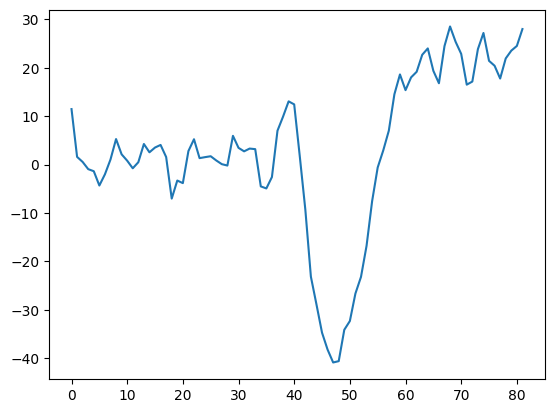

In [13]:
plt.plot(waveform[1,:,5,0])

The percentage of units matched to themselves is: 94.96314496314497%
The percentage of false -ve's then is: 5.03685503685503% 

The rate of miss-match(es) per expected match 0.09705159705159705
The percentage of false +ve's is 0.028569202399813004% for session 1
The percentage of false +ve's is 0.03166735508742944% for session 2
The percentage of false +ve's is 0.04823379202723791% for session 3

This assumes that the spike sorter has made no mistakes


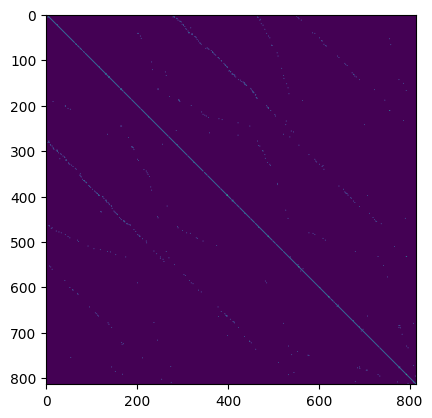

In [7]:
util.evaluate_output(Output, param, WithinSession, SessionSwitch, MatchThreshold = 0.75)

MatchThreshold = 0.5
OutputThreshold = np.zeros_like(Output)
OutputThreshold[Output > MatchThreshold] = 1

plt.imshow(OutputThreshold)


In [8]:
from GUI import *

In [9]:
Amplitude = ExtractedWaveProperties['Amplitude']
SpatialDecay = ExtractedWaveProperties['SpatialDecay']
AvgCentroid = ExtractedWaveProperties['AvgCentroid']
AvgWaveform = ExtractedWaveProperties['AvgWaveform']
AvgWaveformPerTP = ExtractedWaveProperties['AvgWaveformPerTP']
WaveIdx = ExtractedWaveProperties['WaveIdx']
MaxSite = ExtractedWaveProperties['MaxSite']
MaxSiteMean = ExtractedWaveProperties['MaxSiteMean']
process_info_for_GUI(Output, MatchThreshold, Scores2Include, TotalScore, Amplitude, SpatialDecay,
                         AvgCentroid, AvgWaveform, AvgWaveformPerTP, WaveIdx, MaxSite, MaxSiteMean, 
                         waveform, WithinSession, ChannelPos, ClusInfo, param)


In [10]:
IsMatch, NotMatch = run_GUI()

([], [])